# Lab 2 - CMC-13
Equipe:
* Emanuel Reinaldo Gomes Bezerra
* Pedro Pinheiro Borges
* Guilherme Alt Chagas Merklein

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    cohen_kappa_score,
    confusion_matrix,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import joblib

import matplotlib.pyplot as plt


### 1. Preparação dos dados

In [2]:
base_df = pd.read_csv("../data/lab2_2025_dataset.csv")
base_df.dropna(inplace=True)
base_df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [3]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 43.7+ MB


In [4]:
base_df.describe()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [5]:
base_df["Subscription Type"].value_counts(), base_df["Gender"].value_counts(), base_df["Contract Length"].value_counts()

(Subscription Type
 Standard    149128
 Premium     148678
 Basic       143026
 Name: count, dtype: int64,
 Gender
 Male      250252
 Female    190580
 Name: count, dtype: int64,
 Contract Length
 Annual       177198
 Quarterly    176530
 Monthly       87104
 Name: count, dtype: int64)

In [6]:
base_df["Churn"].value_counts()

Churn
1.0    249999
0.0    190833
Name: count, dtype: int64

In [7]:
df = base_df.drop(columns=["CustomerID"])

In [8]:
df.columns

Index(['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls',
       'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend',
       'Last Interaction', 'Churn'],
      dtype='object')

#### Preparação dos Datasets
Estratégia: Separar o dataset original em: Dataset de Treinamento, Dataset de Validação, Dataset de Teste
1. Dados de treinamento utilizados para encontrar um bom modelo de cada um dos três tipos definidos. Treinaremos Árvore de Decisão, Rede Neural MLP e Random Forest. 
2. Tendo o melhor modelo de cada um dos três, aplico-os no Dataset de Validação. Escolho o melhor dos três com base no resultado desta aplicação
3. Agora que tenho o melhor modelo, retreino ele no conjunto Dataset de Treinamento + Dataset de Validação
4. Aplico este modelo no Dataset de Teste e obtenho sua performance

In [9]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [10]:
X_temp, X_test, y_temp, y_test = train_test_split(
  X, y, test_size=0.20, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
  X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

In [11]:
print(f"Tamanho do conjunto de Treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de Validação: {X_val.shape[0]} amostras")
print(f"Tamanho do conjunto de Teste Final: {X_test.shape[0]} amostras\n")

Tamanho do conjunto de Treino: 264498 amostras
Tamanho do conjunto de Validação: 88167 amostras
Tamanho do conjunto de Teste Final: 88167 amostras



#### Pipeline de pré-processamento de dados
Nesta seção, fazemos one-hot encoding das features categóricas e fazemos transformação de escala para as variáveis numéricas.

In [12]:
numerical_columns = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls','Payment Delay', 'Total Spend','Last Interaction',]
categorical_columns = ['Subscription Type', 'Contract Length', 'Gender']

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ],
    remainder="drop",
)

### 2. Criação dos três modelos

A criação dos três modelos pedidos tuna hiperparâmetros com GridSearchCV e 10-Fold Cross Validation, que testa cada uma das combinações de hiperparâmetros em validação cruzada. Os hiperparâmetros testados são os descritos na variável ``config`` correspondente a cada modelo.
Para medida de desempenho, utiliza-se ROC AUC (Area Under the Receiver Operating Characteristic Curve), por ser uma medida de capacidade de distinção que não depende do ponto de corte utilizado, equilibrado o poder discriminatório tanto para a classe 0, quanto para a classe 1. 

Por fim, o modelo é treinado em todos os dados do conjunto de treino com os hiperparâmetros obtidos.

#### 2.a) Modelo baseado em kNN, Árvore de Decisão ou SVM

Dentre as três possibilidades de modelos, escolheu-se um classificador baseado em Árvore de Decisão.

In [ ]:
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_config = {
  "classifier__criterion": ['gini', 'entropy'],
  "classifier__max_depth": [10, 12],
  "classifier__min_samples_leaf": [3, 5, 10],
}

decision_tree_pipeline = Pipeline(
  steps=[("preprocessor", preprocessor), ("classifier", decision_tree_model)]
)
decision_tree_grid_search = GridSearchCV(
  decision_tree_pipeline, decision_tree_config, cv=10, scoring="roc_auc", n_jobs=-1
)

decision_tree_grid_search.fit(X_train, y_train)

decision_tree_model_hyperparams = {
  k.replace("classifier__", ""): v for k, v in decision_tree_grid_search.best_params_.items()
}

print(f"Performance (ROC AUC) {decision_tree_grid_search.best_score_} obtida com os hiperparâmetros da DecisionTree: {decision_tree_model_hyperparams}")

Performance 0.9999590099979307 obtida com os hiperparâmetros da DecisionTree: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 10}


In [15]:
decision_tree_pipeline = Pipeline(
  steps=[("preprocessor", preprocessor), ("classifier", decision_tree_model.set_params(**decision_tree_model_hyperparams))]
)

decision_tree_pipeline.fit(X_train, y_train)
print("Decision Tree treinada com os melhores hiperparâmetros")

joblib.dump(decision_tree_pipeline, "decision_tree_pipeline.joblib")
print(f"Modelo decision_tree_pipeline salvo")

Decision Tree treinada com os melhores hiperparâmetros
Modelo decision_tree_pipeline salvo


Performance ROC AUC 0.9999590099979307 obtida com os hiperparâmetros da DecisionTree: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 10}


#### 2.b) Modelo baseado em Redes Neurais do tipo MLP (MultiLayer Perceptron)

In [ ]:
nn_mlp_model = MLPClassifier(random_state=42, max_iter=1000, early_stopping=True)
nn_mlp_config = {
  "classifier__hidden_layer_sizes": [(100,), (50, 50), (100, 50), (100, 100)],
  "classifier__alpha": [0.0001, 0.0005, 0.001],
}

nn_mlp_pipeline = Pipeline(
  steps=[("preprocessor", preprocessor), ("classifier", nn_mlp_model)]
)
nn_mlp_grid_search = GridSearchCV(
  nn_mlp_pipeline, nn_mlp_config, cv=10, scoring="roc_auc", n_jobs=4
)

nn_mlp_grid_search.fit(X_train, y_train)

nn_mlp_model_hyperparams = {
  k.replace("classifier__", ""): v for k, v in nn_mlp_grid_search.best_params_.items()
}

print(f"Performance (ROC AUC) {nn_mlp_grid_search.best_score_} obtida com os hiperparâmetros da Rede Neural MLP: {nn_mlp_model_hyperparams}")

Performance 0.9999910083254735 obtida com os hiperparâmetros da Rede Neural MLP: {'alpha': 0.0005, 'hidden_layer_sizes': (100, 100)}


In [17]:
nn_mlp_pipeline = Pipeline(
  steps=[("preprocessor", preprocessor), ("classifier", nn_mlp_model.set_params(**nn_mlp_model_hyperparams))]
)

nn_mlp_pipeline.fit(X_train, y_train)
print("Rede Neural MLP treinada com os melhores hiperparâmetros")

joblib.dump(nn_mlp_pipeline, "nn_mlp_pipeline.joblib")
print(f"Modelo nn_mlp_pipeline salvo")

Rede Neural MLP treinada com os melhores hiperparâmetros
Modelo nn_mlp_pipeline salvo


Performance ROC AUC 0.9999910083254735 obtida com os hiperparâmetros da Rede Neural MLP: {'alpha': 0.0005, 'hidden_layer_sizes': (100, 100)}


#### 2.c) Modelo baseado em Comitês (Random Forests, AdamBoost, etc)
Dentre as possibilidades, escolheu-se um modelo classificador RandomForest.

In [ ]:
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_config = {
  "classifier__n_estimators": [100, 200, 400],
  "classifier__max_features": ["sqrt", "log2"],
  "classifier__max_depth": [10, 12],
  "classifier__min_samples_leaf": [5, 10],
}

random_forest_pipeline = Pipeline(
  steps=[("preprocessor", preprocessor), ("classifier", random_forest_model)]
)
random_forest_grid_search = GridSearchCV(
  random_forest_pipeline, random_forest_config, cv=10, scoring="roc_auc", n_jobs=4
)

random_forest_grid_search.fit(X_train, y_train)

random_forest_model_hyperparams = {
  k.replace("classifier__", ""): v for k, v in random_forest_grid_search.best_params_.items()
}

print(f"Performance (ROC AUC) {random_forest_grid_search.best_score_} obtida com os hiperparâmetros da Random Forest: {random_forest_model_hyperparams}")

Performance 0.9999513653287119 obtida com os hiperparâmetros da Random Forest: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}


In [19]:
random_forest_pipeline = Pipeline(
  steps=[("preprocessor", preprocessor), ("classifier", random_forest_model.set_params(**random_forest_model_hyperparams))]
)

random_forest_pipeline.fit(X_train, y_train)
print("Random Forest treinada com os melhores hiperparâmetros")

joblib.dump(random_forest_pipeline, "random_forest_pipeline.joblib")
print(f"Modelo random_forest_pipeline salvo")

Random Forest treinada com os melhores hiperparâmetros
Modelo random_forest_pipeline salvo


Performance ROC AUC 0.9999513653287119 obtida com os hiperparâmetros da Random Forest: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}


### 3. Análise comparativa do desempenho dos modelos

Para obtenção das medidas de desempenho, tem-se a célula de código abaixo. Calcula-se Acurácia, Precisão, Recall, F1-Score e Kappa. 

Para todas as medidas, a Decision Tree é a que apresenta melhores resultados. A acurácia no conjunto de validação foi de 0.999501, enquanto no treino temos 0.999357, a proximidade nos valores mostra que o modelo provavelmente não sobreajustou.

--- Relatório para o modelo: DecisionTree ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38167
         1.0       1.00      1.00      1.00     50000

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167

Cohen's Kappa: 0.9990
---------------------------------------------


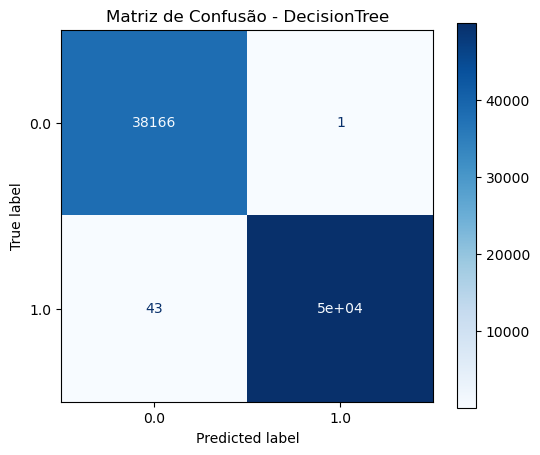

--- Relatório para o modelo: MLP ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38167
         1.0       1.00      1.00      1.00     50000

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167

Cohen's Kappa: 0.9988
---------------------------------------------


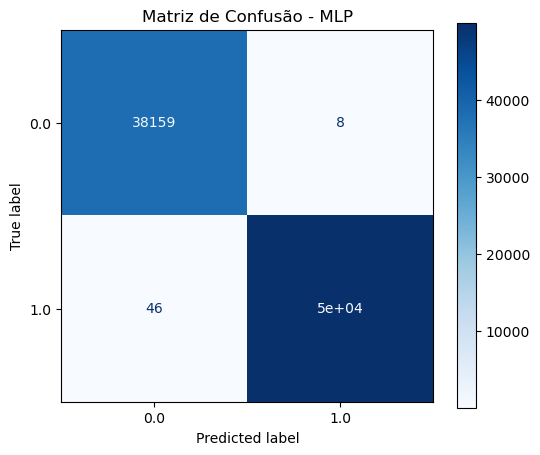

--- Relatório para o modelo: RandomForest ---
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     38167
         1.0       1.00      0.99      0.99     50000

    accuracy                           0.99     88167
   macro avg       0.99      0.99      0.99     88167
weighted avg       0.99      0.99      0.99     88167

Cohen's Kappa: 0.9860
---------------------------------------------


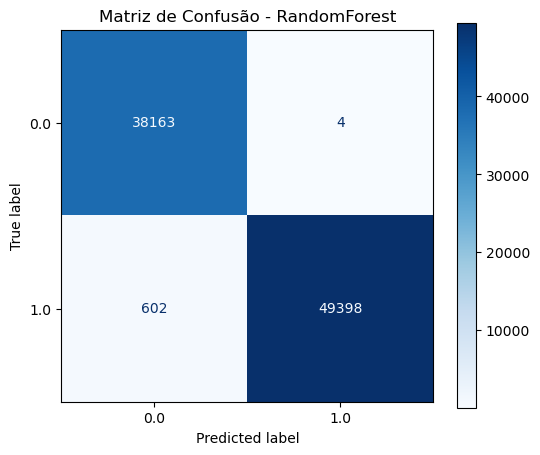


Resumo Comparativo das Métricas de Validação
              Acurácia do Treino  Acurácia  Precisão   Recall  F1-Score  \
DecisionTree            0.999357  0.999501  0.999980  0.99914  0.999560   
MLP                     0.999471  0.999388  0.999840  0.99908  0.999460   
RandomForest            0.992367  0.993127  0.999919  0.98796  0.993904   

                 Kappa  
DecisionTree  0.998984  
MLP           0.998753  
RandomForest  0.986027  
{'DecisionTree': 0.9995009470663627, 'MLP': 0.9993875259450815, 'RandomForest': 0.993126680050359}
Modelo escolhido: DecisionTree com acurácia de 0.9995009470663627


In [26]:
pipelines = {
  "DecisionTree": decision_tree_pipeline, # joblib.load("src/decision_tree_pipeline")
  "MLP": nn_mlp_pipeline, # joblib.load("src/nn_mlp_pipeline")
  "RandomForest": random_forest_pipeline, # joblib.load("src/random_forest_pipeline")
}
############################
validation_results = {}

for model_name, pipeline in pipelines.items():
    
    y_pred = pipeline.predict(X_val)
    
    training_accuracy = accuracy_score(y_train, pipeline.predict(X_train))
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    kappa = cohen_kappa_score(y_val, y_pred)
    
    validation_results[model_name] = {
        'Acurácia do Treino': training_accuracy,
        'Acurácia': accuracy,
        'Precisão': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Kappa': kappa
    }
    
    print(f"--- Relatório para o modelo: {model_name} ---")
    print(classification_report(y_val, y_pred))
    print(f"Cohen's Kappa: {kappa:.4f}")
    print("-" * 45)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    ConfusionMatrixDisplay.from_predictions(y_val, y_pred, ax=ax, cmap='Blues')
    ax.set_title(f'Matriz de Confusão - {model_name}')
    plt.show()

results_df = pd.DataFrame(validation_results).T 

print("\nResumo Comparativo das Métricas de Validação")
print(results_df)



############################ Seleção automática com base na acurácia
validation_score = {
  "DecisionTree": decision_tree_pipeline.score(X_val, y_val),
  "MLP": nn_mlp_pipeline.score(X_val, y_val),
  "RandomForest": random_forest_pipeline.score(X_val, y_val),
}

print(validation_score)

champion_model_name = max(validation_score, key=validation_score.get)
print(f"Modelo escolhido: {champion_model_name} com acurácia de {validation_score[champion_model_name]}")

#### Retreinando o melhor modelo com os dados de Treino e Validação

In [21]:
final_pipeline = pipelines[champion_model_name]
final_pipeline.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Tenure',
                                                   'Usage Frequency',
                                                   'Support Calls',
                                                   'Payment Delay',
                                                   'Total Spend',
                                                   'Last Interaction']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Subscription Type',
                                                   'Contract Length',
                                                   'Gender'])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=12,
                                        min_samples_leaf=10,
                                        random_state=42))])

### 4. Aplicação da predição do Modelo Desenvolvido

In [22]:
y_pred_final = final_pipeline.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final)

print(f"Acurácia Final do Modelo no Conjunto de Teste: {final_accuracy:.4f}")

Acurácia Final do Modelo no Conjunto de Teste: 0.9996


Acurácia Final do Modelo no Conjunto de Teste: 0.9996


#### Exportando modelo

In [23]:
filename = "model.joblib"
joblib.dump(final_pipeline, filename)
print(f"Modelo final salvo em '{filename}'")

Modelo final salvo em 'model.joblib'


### 5. Conclusões